In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## 0. Load data

In [ ]:
# load data
path = 'drive/My Drive/P8/data'
train = pd.read_csv(os.path.join(path, "train_I1.csv"), encoding='utf8', dtype={'text_id': int, 'sentence': str, 'label': int})
val = pd.read_csv(os.path.join(path, "val_I1.csv"), encoding='utf8', dtype={'text_id': int, 'sentence': str, 'label': int})
test = pd.read_csv(os.path.join(path, "test_I1.csv"), encoding='utf8', dtype={'text_id': int, 'sentence': str, 'label': int})

## 1. Basic data exploration

In [ ]:
print(train.shape)
print(val.shape)
print(test.shape)

(1380, 3)
(172, 3)
(173, 3)


In [ ]:
print(train.head())

   text_id                                           sentence  label
0       89  schliesslich Kapitel . aufzeigen hinsichtlich ...      5
1       26  zusammengefasst Arbeit Entwicklungsarbeit Ziel...      7
2       19  Masterarbeit möchten kritisch Thema Frau Mädch...      7
3       70   Ergebnis Diskussionsteil erklären interpretieren      5
4       52  Sekundarlehrperson interessieren erster Linie ...      0


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


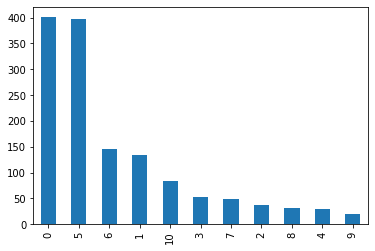

In [ ]:
fig, ax = plt.subplots()
print(train['label'].value_counts().plot(ax=ax, kind='bar'))
print(val['label'].value_counts().plot(ax=ax, kind='bar'))
print(test['label'].value_counts().plot(ax=ax, kind='bar'))

It is a problem that we have so many classes that we barely have data for...
Option 1: Further undersample data
Option 2: Build mulitple models for binary classification, starting with class 5 vs. the rest...

In [ ]:
# count occurances
train['label'].value_counts() # class 5: 398

0     401
5     398
6     146
1     133
7      83
10     52
2      48
8      38
3      31
9      30
4      20
Name: label, dtype: int64

In [ ]:
val['label'].value_counts() # class 5: 52

5     52
0     47
1     21
6     16
7     10
10     7
8      6
2      5
9      4
3      3
4      1
Name: label, dtype: int64

In [ ]:
test['label'].value_counts() # class 5: 41

0     52
5     41
6     22
1     20
10    10
3      8
7      8
2      7
8      3
4      1
9      1
Name: label, dtype: int64

## Classification: first attempts

New idea: Multiple subnets

If we want to keep the classes even and maximize the dataset for each class, we can frame this task as a binary classification task for each class which then later can be combined for a final decision. 
E.g. sentence 1 will be loaded into 11 seperate networks that classify it into 
- cls 1 or other
- cls 2 or other
- cls 3 or other
- ...
- cls 11 or other. 

At the end, the scores can be compared and the sentence will be sorted into the class with the highest percentage score. This might be an advantageous approach if we consider that we can then also incorporate different kinds of preprocessing for each subnet.

I will start with classifying one of the network and sorting data into classes 5 or other. 
Btw. class 5 is step 2c (Forschungslücke). 



### Subnet A: Class 5 or other

A1. Preprocessing for binary classification


In [ ]:
# sample data: 
# train: keep all instances of class 5 and 400 random other rows 
subset_train5 = pd.concat([
    train[train['label'] == 5],  # keep all rows with label 5
    train[train['label'] != 5].sample(n=400, random_state=42)  # sample 500 rows with other labels
]).dropna()
# val: keep all instances of class 5 and 50 random other rows 
subset_val5 = pd.concat([
    val[val['label'] == 5],  # keep all rows with label 5
    val[val['label'] != 5].sample(n=50, random_state=42)  # sample 500 rows with other labels
]).dropna()
# test: keep all instances of class 5 and 50 random other rows
subset_test5 = pd.concat([
    test[test['label'] == 5],  # keep all rows with label 5
    test[test['label'] != 5].sample(n=50, random_state=42)  # sample 500 rows with other labels
]).dropna()

In [ ]:
# new labels: 1 if class 5, 0 if any other class
subset_train5['new_label'] = [int(1) if x == 5 else int(0) for x in subset_train5["label"]]
subset_val5['new_label'] = [int(1) if x == 5 else int(0) for x in subset_val5["label"]]
subset_test5['new_label'] = [int(1) if x == 5 else int(0) for x in subset_test5["label"]]

In [ ]:
# drop unnecessary columns
subset_train5 = subset_train5.drop(["text_id", "label"], axis = 1)
subset_val5 = subset_val5.drop(["text_id", "label"], axis = 1)
subset_test5 = subset_test5.drop(["text_id", "label"], axis = 1)

<AxesSubplot:>

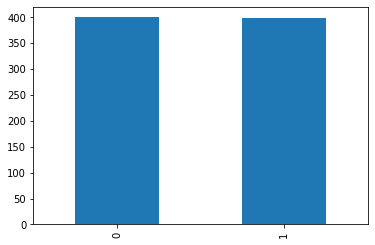

In [ ]:
fig, ax = plt.subplots()
subset_train5['new_label'].value_counts().plot(ax=ax, kind='bar')
#subset_val['new_label'].value_counts().plot(ax=ax, kind='bar')
#subset_test['new_label'].value_counts().plot(ax=ax, kind='bar')

In [ ]:
len(subset_train5), len(subset_val5), len(subset_test5)

(798, 101, 91)

In [ ]:
subset_test5.head()

,sentence,new_label
0,theoretisch Teil Arbeit finden Abstützung Beru...,1
2,Arbeit bestehen fünf Hauptteil theoretisch Tei...,1
3,zweiter Kapitel gehen nah Betrachtung Motivbeg...,1
6,dabei zeigen einleitend Professionalisierung L...,1
7,zuerst Abhängigkeitsverhältnis DDR Sowjetunion...,1


A2. Convert Dataframe -> Dataset

In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('new_label')
  dataframe = dataframe["sentence"]
  #dataframe = dataframe.apply(lambda x: str(x))
  ds = tf.data.Dataset.from_tensor_slices((dataframe, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [ ]:
train_data = df_to_dataset(subset_train5)
val_data = df_to_dataset(subset_val5)
test_data = df_to_dataset(subset_test5)

In [ ]:
# todo: encoding of umlaute is weird -> check if this is something i need to fix https://www.tensorflow.org/text/guide/unicode
#list(train_data)[0]

In [ ]:
#s = b"l\xc3\xb6sungsorientiert Konfliktbew\xc3\xa4ltigung erm\xc3\xb6glichen"
#decoded = s.decode('utf-8')
#print(decoded)

A3. Embedding
https://tfhub.dev/google/nnlm-de-dim50/2

In [ ]:
import tensorflow_hub as hub

In [ ]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-de-dim50/2",
                           dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(32, 50), dtype=float32, numpy=
array([[-0.11161539, -0.12223903,  0.01683075, ..., -0.07183117,
        -0.05232792, -0.3709021 ],
       [-0.02411753,  0.13084924,  0.03698444, ...,  0.08933611,
        -0.2168662 , -0.00181213],
       [-0.21515311, -0.10575402, -0.00482263, ...,  0.2648246 ,
        -0.25975978, -0.05776104],
       ...,
       [-0.1243261 ,  0.24802072,  0.2065657 , ...,  0.08813307,
        -0.1929972 , -0.1274959 ],
       [ 0.07297941,  0.12316076,  0.01661296, ...,  0.13328347,
        -0.17124565, -0.19803578],
       [ 0.05112859,  0.10568976,  0.10050578, ..., -0.0415312 ,
        -0.29700994, -0.10652219]], dtype=float32)>

A4: classification

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer) # embedding
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

binary crossentropy & accuracy because we're doing binary classificaiton

In [ ]:
# evaluate untrained model on training data
model.evaluate(train_data)

25/25 [==============================] - 5s 171ms/step - loss: 0.7298 - accuracy: 0.4010


[0.7297751307487488, 0.4010024964809418]

In [ ]:
# evaluate untrained model on val data
model.evaluate(val_data)

4/4 [==============================] - 1s 171ms/step - loss: 0.7093 - accuracy: 0.4752


[0.7093133926391602, 0.4752475321292877]

In [ ]:
history = model.fit(train_data, epochs = 6, validation_data=val_data)

Epoch 1/6
25/25 [==============================] - 34s 1s/step - loss: 0.6113 - accuracy: 0.6842 - val_loss: 0.5920 - val_accuracy: 0.7822
Epoch 2/6
25/25 [==============================] - 37s 1s/step - loss: 0.5359 - accuracy: 0.7732 - val_loss: 0.5161 - val_accuracy: 0.8317
Epoch 3/6
25/25 [==============================] - 34s 1s/step - loss: 0.4234 - accuracy: 0.8747 - val_loss: 0.4375 - val_accuracy: 0.8416
Epoch 4/6
25/25 [==============================] - 34s 1s/step - loss: 0.3437 - accuracy: 0.9123 - val_loss: 0.3756 - val_accuracy: 0.8713
Epoch 5/6
25/25 [==============================] - 35s 1s/step - loss: 0.2503 - accuracy: 0.9574 - val_loss: 0.3356 - val_accuracy: 0.8614
Epoch 6/6
25/25 [==============================] - 37s 1s/step - loss: 0.2038 - accuracy: 0.9624 - val_loss: 0.3157 - val_accuracy: 0.8713


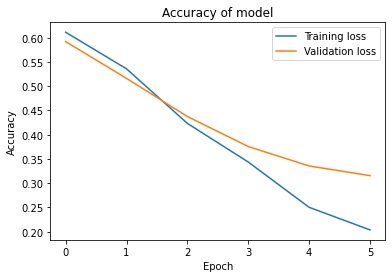

In [ ]:
# check for overfitting
plt.plot(history.history['loss'], label ="Training loss")
plt.plot(history.history['val_loss'], label ="Validation loss")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data)

3/3 [==============================] - 1s 397ms/step - loss: 0.3698 - accuracy: 0.8352


[0.36976808309555054, 0.8351648449897766]

# LSTM

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'kapitel', 'arbeit', 'teil', 'theoretisch',
       'ergebnis', 'fragestellung', 'schüler', 'lehrperson', 'erster',
       'schülerin', 'folgen', 'sowie', 'untersuchung', 'schule',
       'begriff', 'vorstellen', 'zwei', 'verschieden'], dtype='<U28')

In [ ]:
model = tf.keras.Sequential([
    encoder, 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ), 
    tf.keras.layers.LSTM(32), 
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# evaluate untrained model on training data
model.evaluate(train_data)

25/25 [==============================] - 9s 6ms/step - loss: 0.6933 - accuracy: 0.4925


[0.6932609677314758, 0.49248120188713074]

In [ ]:
# evaluate untrained model on training data
model.evaluate(val_data)

4/4 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.5149


[0.6932076215744019, 0.5148515105247498]

In [ ]:
history = model.fit(train_data, epochs = 6, validation_data=val_data)

Epoch 1/6
25/25 [==============================] - 8s 21ms/step - loss: 0.6884 - accuracy: 0.5915 - val_loss: 0.6769 - val_accuracy: 0.7624
Epoch 2/6
25/25 [==============================] - 1s 26ms/step - loss: 0.6142 - accuracy: 0.8521 - val_loss: 0.4972 - val_accuracy: 0.8416
Epoch 3/6
25/25 [==============================] - 1s 38ms/step - loss: 0.3140 - accuracy: 0.9348 - val_loss: 0.3974 - val_accuracy: 0.8614
Epoch 4/6
25/25 [==============================] - 1s 37ms/step - loss: 0.1635 - accuracy: 0.9687 - val_loss: 0.4154 - val_accuracy: 0.9010
Epoch 5/6
25/25 [==============================] - 1s 35ms/step - loss: 0.1040 - accuracy: 0.9825 - val_loss: 0.4395 - val_accuracy: 0.8911
Epoch 6/6
25/25 [==============================] - 1s 39ms/step - loss: 0.0919 - accuracy: 0.9875 - val_loss: 0.4706 - val_accuracy: 0.9208


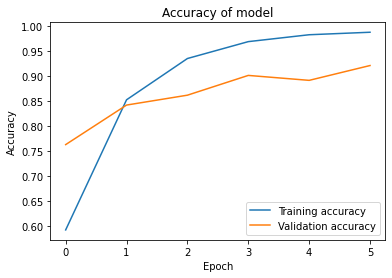

In [ ]:
# check for overfitting
plt.plot(history.history['accuracy'], label ="Training accuracy")
plt.plot(history.history['val_accuracy'], label ="Validation accuracy")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data)

3/3 [==============================] - 0s 13ms/step - loss: 0.4585 - accuracy: 0.8901


[0.45851361751556396, 0.8901098966598511]

# CNN

TODO - An Anna: das musst du noch nicht anschauen.